# Distributed modeling with static schedule
We demonstrate using 2 workers to model 4 shots across Marmousi with a static distribution.

In [1]:
using Distributed, PyPlot

In [2]:
addprocs(2)

2-element Array{Int64,1}:
 2
 3

In [3]:
@everywhere using DistributedArrays, DistributedJets, Jets, WaveFD, JetPackWaveFD, Random

## Define the model 
Even though this is a 2D example, the model passed to the nonlinear operator below is 3D, with size [nz,nx,1] for the velocity only case. In the case of variable density acoustics, the model would be of size [nz,nx,2]. 

In [4]:
v = read!("../20_marmousi_model_setup/marmousi_vp_20m_176x851.bin", Array{Float32}(undef,176,851));
dz,dx = 20.0,20.0
nz,nx = size(v)
m = reshape(v, (nz,nx,1))
@show dz,dx
@show size(v)
@show size(m);

(dz, dx) = (20.0, 20.0)
size(v) = (176, 851)
size(m) = (176, 851, 1)


In [5]:
sx = range(0,length=4,stop=(851-1)*20)
nshots = length(sx)
@show nshots;

nshots = 4


## Note on scratch space for temporary files
When dealing with multiple serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [6]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

In [7]:
@everywhere function makeF(i,sx)
    nz,nx,dz,dx = 176,851,20.0,20.0    
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = 1601,
        dtrec = 0.004,
        dtmod = 0.002,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=5.0),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        srcfieldfile = joinpath(scratch, "field-$i.$(randstring()).bin"),
        reportinterval=1000)
end

In [8]:
F = @blockop DArray(I->[makeF(i,sx) for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (176, 851, 1) → (5449804,)"

In [9]:
d = F*m;

[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-3.R0SWzy85.bin
[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-1.KJVNlnmb.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  3201  156.91 MCells/s (IO=50.76, EX=34.12, PR= 6.66) -- rms d,p; 1.3196e+00 9.9564e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  3201  125.69 MCells/s (IO=40.61, EX=24.41, PR=26.19) -- rms d,p; 9.6169e-01 7.7778e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  2000 of  3201  147.41 MCells/s (IO=48.20, EX=29.73, PR= 7.93) -- rms d,p; 1.4763e+00 3.6917e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  2000 of  3201  137.42 MCells/s (IO=45.41, EX=23.66, PR=17.15) -- rms d,p; 1.0639e+00 3.0163e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  3000 of  3201  152.58 MCells/s (IO=50.45, EX=29.97, PR= 9.46) -- rms d,p; 1.5016e+00 1.0463e-01
[ Info: Pr

## Plot the shots

In [10]:
# fetch shot gathers from the `DArray` distributed on the workers
shots = [getblock(d, i) for i in 1:nshots];

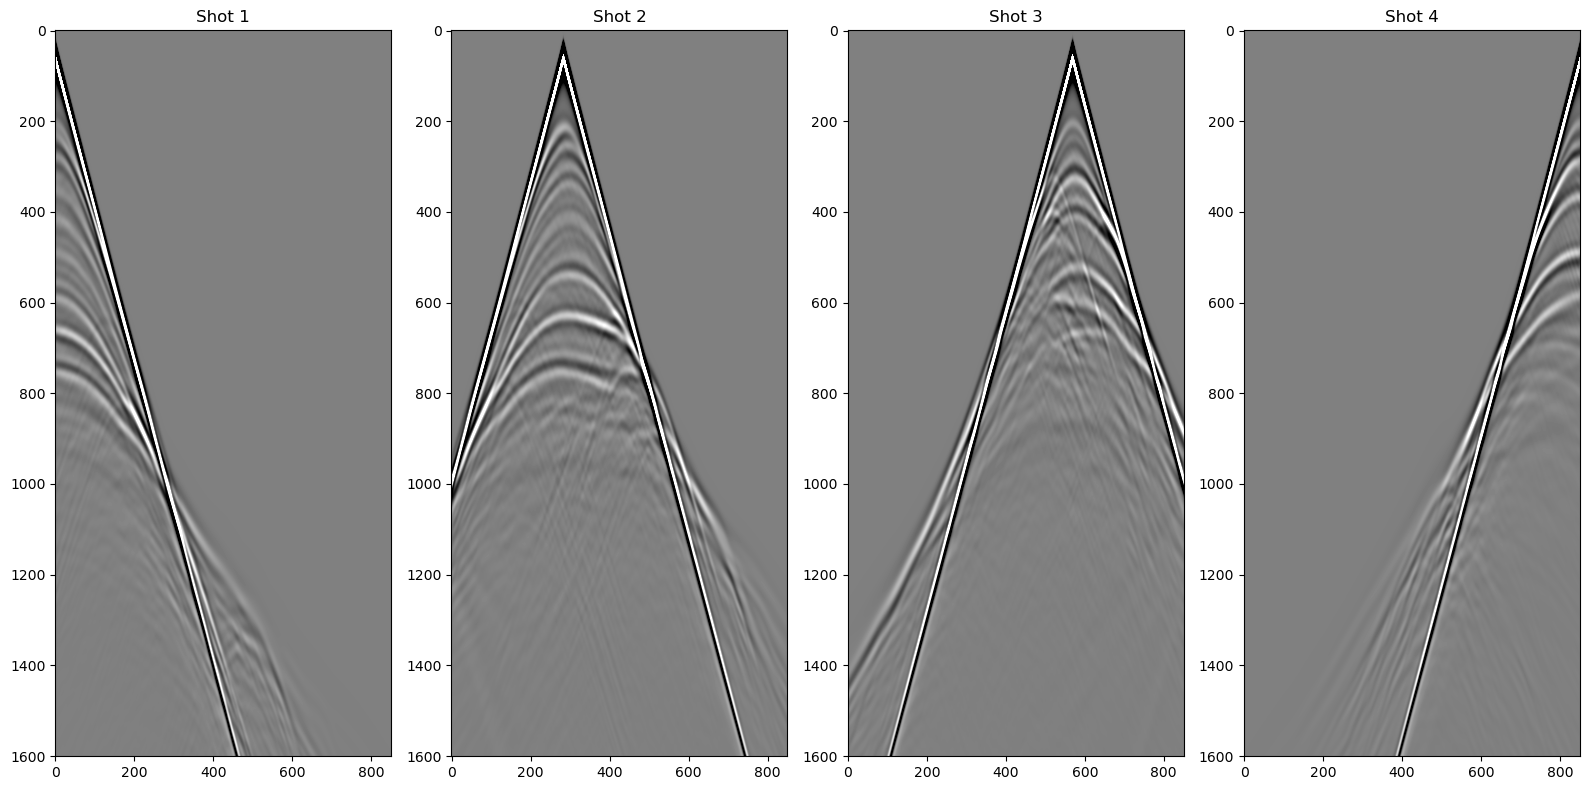

In [11]:
dmax = maximum(abs, extrema(d))
figure(figsize=(16,8)); clf()
for k in 1:nshots
    subplot(1,4,k)
    imshow(shots[k], aspect="auto", cmap="gray")
    clim(0.025 .* [-dmax,+dmax])
    title("Shot $(k)")
end
tight_layout()
nothing

## Remove source field files on local disk

In [12]:
close(F);

## Remove workers

In [13]:
rmprocs(workers());